In [1]:
import pandas as pd
import numpy as np
%matplotlib inline


In [2]:
DataWalmart = pd.read_csv("https://raw.githubusercontent.com/ga-students/SF-DAT-20/master/Data/train.csv")

Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:
    
    Store - the store number

    Dept - the department number

    Date - the week

    Weekly_Sales - sales for the given department in the given store

    IsHoliday - whether the week is a special holiday week

#### Load the data and set index to Date


In [3]:
DataWalmart['Date'] = pd.to_datetime(DataWalmart['Date'])
DataWalmart.set_index('Date', inplace=True)
DataWalmart.head(4)

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store. Let's call new dataset store1_sales and its variable "Weekly_Sales"


In [4]:
store1_sales = DataWalmart[DataWalmart.Store == 1][['Weekly_Sales']].resample('W', 'sum')
store1_sales.head()

,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the Weekly_Sales. What general trends do you observe?


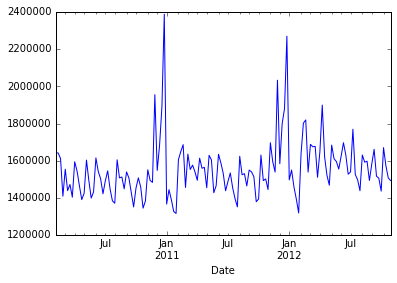

In [5]:
store1_sales.Weekly_Sales.plot()

Answer: We can observe that close to Jan, sales increase.

#### Create an autocorrelation plot and explain your findings

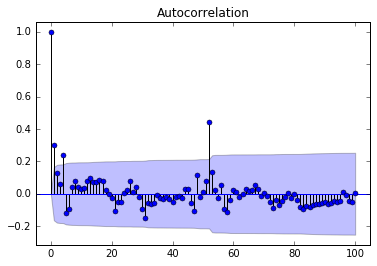

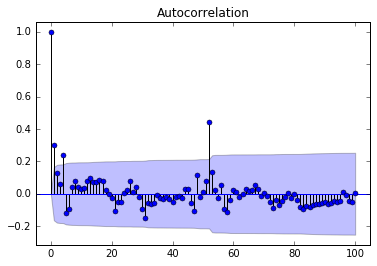

In [6]:

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales['Weekly_Sales'], lags=100)

Answer: Components 1,2,3 and 4 seem particularly useful for autoregression.

In the plot above notice, spike at around 52 - implying a yearly pattern as well

No random spikes, probably not much use for a moving average model

#### Split the weekly sales data in a training and test set - using 80% of the data for training

In [7]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.8*n)]
test = store1_sales.Weekly_Sales[int(.8*n):]

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [8]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [9]:
print test.index[0]
print test.index[len(test)-1]

2012-04-15 00:00:00
2012-10-28 00:00:00


In [10]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict('2012-04-15','2012-10-28')
print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 68274.840662049231)


//anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                     ARMA(1, 0)   Log Likelihood               -1528.189
Method:                       css-mle   S.D. of innovations         160453.395
Date:                Mon, 21 Mar 2016   AIC                           3062.379
Time:                        11:58:05   BIC                           3070.587
Sample:                    02-07-2010   HQIC                          3065.710
                         - 04-08-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.551e+06    2.2e+04     70.487      0.000      1.51e+06  1.59e+06
ar.L1.Weekly_Sales     0.3198      0.090      3.546      0.001         0.143     0.497
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1271           +0.0000j            3.1271            0.0000
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

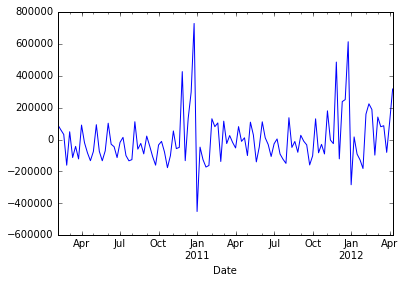

In [11]:
model.resid.plot()


Answer: Everything seems to be fine except end of DEC close to Jan.

#### Compute and AR(2) model and an ARIMA(3, 1,1) model - does this improve your mean absolute error on the held out set.


In [12]:

model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict('2012-04-15','2012-10-28')

print("Mean absolute error: ", mean_absolute_error(test, predictions))


('Mean absolute error: ', 68875.091873053709)


In [13]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict('2012-04-15','2012-10-28')

print("Mean absolute error: ", mean_absolute_error(test, predictions))

('Mean absolute error: ', 64885.807095032724)


#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.


In [14]:
model = sm.tsa.ARIMA(train, (3, 1, 1)).fit()

predictions = model.predict('2012-04-15','2012-10-28',dynamic=False,typ='levels')

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 214170.14362760083)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  113
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1516.984
Method:                       css-mle   S.D. of innovations         163124.705
Date:                Mon, 21 Mar 2016   AIC                           3045.968
Time:                        11:58:15   BIC                           3062.333
Sample:                    02-14-2010   HQIC                          3052.609
                         - 04-08-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                 2265.3626   7498.641      0.302      0.763     -1.24e+04   1.7e+04
ar.L1.D.Weekly_Sales    -0.9070      0.150     -6.045      0.000        -1.201    -0.613
ar.L2.D.Weekly_Sales    -0.5741      0.119     -4.810      0.000        -0.808    -0.340
ar.L3.D.Weekly_Sales    -0.4386      0.085     -5.146      0.000        -0.606    -0.272
ma.L1.D.Weekly_Sales     0.4146      0.152      2.725      0.008         0.116     0.713
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1861           -0.0000j            1.1861           -0.5000
AR.2           -0.0614           -1.3850j            1.3864           -0.2570
AR.3           -0.0614           +1.3850j            1.3864            0.2570
MA.1           -2.4121           +0.0000j            2.4121            0.5000
-----------------------------------------------------------------------------
"""

Answer: It seems like ARMA(2,2) results in lowest test error. 

# A better way to tune our ARIMA model

60503.2482757


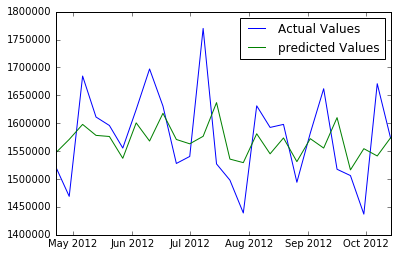

In [25]:
# Let's test our model on last 20% of data
p = 4
d = 0
q = 1
TestRatio = 0.20
pred = []
indexData = []
ActualObservations = []
n = len( store1_sales.Weekly_Sales)
for i in range(1,int(TestRatio*n-1)):
    train =  store1_sales.Weekly_Sales[:(int((1-TestRatio)*n+i))]
    #print train.tail(1)
    test =  store1_sales.Weekly_Sales[(int((1-TestRatio)*n+i)):]
    #print test
    #print train
    model = sm.tsa.ARIMA(train,(p, d, q)).fit()
    predictions = model.predict(start = str(test.index.date[0]), end= str(test.index.date[0])) 
    #if d > 0 you must set  
    # model.predict(start = str(test.index.date[0]), end= str(test.index.date[0]),dynamic = False, typ ='levels')
    pred.append(predictions[0])
    indexData.append(test.index.date[0])
    ActualObservations.append( store1_sales.Weekly_Sales[test.index.date[0]])
    #print predictions

PredictActualDataFrame = pd.DataFrame({'predicted Values':pred,
                                       'Actual Values':ActualObservations,
                                       },index = indexData)
PredictActualDataFrame.plot()

MAD = (mean_absolute_error(pred, ActualObservations)) 
print MAD